# Peter en de Wolf: Introductie tot Reinforcement Learning

In deze tutorial leren we hoe we Reinforcement Learning kunnen toepassen op een probleem van padvinding. De setting is geïnspireerd door [Peter en de Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), een muzikaal sprookje van de Russische componist [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Het is een verhaal over de jonge pionier Peter, die moedig zijn huis verlaat om naar de open plek in het bos te gaan en de wolf achterna te zitten. We zullen machine learning-algoritmen trainen die Peter helpen om het omliggende gebied te verkennen en een optimale navigatiekaart te bouwen.

Laten we eerst een aantal handige bibliotheken importeren:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overzicht van Reinforcement Learning

**Reinforcement Learning** (RL) is een leertechniek waarmee we het optimale gedrag van een **agent** in een bepaalde **omgeving** kunnen leren door veel experimenten uit te voeren. Een agent in deze omgeving moet een **doel** hebben, dat wordt gedefinieerd door een **beloningsfunctie**.

## De Omgeving

Voor de eenvoud beschouwen we Peter's wereld als een vierkant bord van grootte `width` x `height`. Elke cel op dit bord kan één van de volgende zijn:
* **grond**, waarop Peter en andere wezens kunnen lopen
* **water**, waarop je uiteraard niet kunt lopen
* **een boom** of **gras** - een plek waar je even kunt uitrusten
* **een appel**, wat iets vertegenwoordigt dat Peter graag zou vinden om zichzelf te voeden
* **een wolf**, die gevaarlijk is en vermeden moet worden

Om met de omgeving te werken, definiëren we een klasse genaamd `Board`. Om deze notebook niet te veel te belasten, hebben we alle code om met het bord te werken verplaatst naar een aparte module genaamd `rlboard`, die we nu gaan importeren. Je kunt in deze module kijken voor meer details over de interne implementatie.


In [2]:
from rlboard import *

Laten we nu een willekeurig bord maken en kijken hoe het eruitziet:


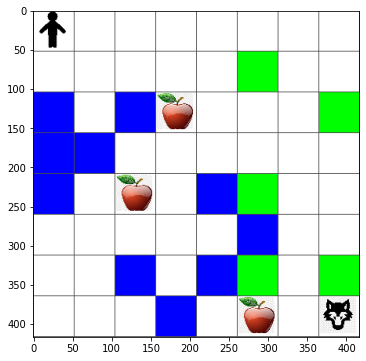

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Acties en Beleid

In ons voorbeeld is het doel van Peter om een appel te vinden, terwijl hij de wolf en andere obstakels vermijdt. Om dit te doen, kan hij in principe rondlopen totdat hij een appel vindt. Bij elke positie kan hij kiezen uit een van de volgende acties: omhoog, omlaag, naar links en naar rechts. We zullen deze acties definiëren als een woordenboek en ze koppelen aan paren van bijbehorende coördinatenwijzigingen. Bijvoorbeeld, naar rechts bewegen (`R`) komt overeen met het paar `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

De strategie van onze agent (Peter) wordt bepaald door een zogenaamde **policy**. Laten we de eenvoudigste policy bekijken, genaamd **random walk**.

## Random walk

Laten we eerst ons probleem oplossen door een random walk-strategie te implementeren.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Laten we het experiment met willekeurige stappen meerdere keren uitvoeren en het gemiddelde aantal genomen stappen bekijken:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Beloningsfunctie

Om ons beleid slimmer te maken, moeten we begrijpen welke zetten "beter" zijn dan andere.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Bouw een Q-Table, of een multidimensionale array. Aangezien ons bord afmetingen heeft van `breedte` x `hoogte`, kunnen we de Q-Table weergeven met een numpy-array met de vorm `breedte` x `hoogte` x `len(acties)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Geef de Q-Table door aan de plotfunctie om de tabel op het bord te visualiseren:


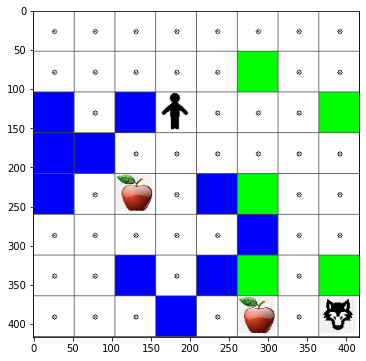

In [9]:
m.plot(Q)

## Essentie van Q-Learning: Bellman-vergelijking en leeralgoritme

Schrijf een pseudocode voor ons leeralgoritme:

* Initialiseer de Q-Tabel Q met gelijke waarden voor alle toestanden en acties
* Stel de leersnelheid in $\alpha\leftarrow 1$
* Herhaal de simulatie meerdere keren
   1. Begin op een willekeurige positie
   1. Herhaal
        1. Kies een actie $a$ in toestand $s$
        2. Voer de actie uit door naar een nieuwe toestand $s'$ te gaan
        3. Als we een eindspelconditie tegenkomen, of de totale beloning te klein is - beëindig de simulatie  
        4. Bereken de beloning $r$ in de nieuwe toestand
        5. Werk de Q-Functie bij volgens de Bellman-vergelijking: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Werk de totale beloning bij en verlaag $\alpha$.

## Exploiteren vs. Verkennen

De beste aanpak is een balans te vinden tussen verkennen en exploiteren. Naarmate we meer leren over onze omgeving, zullen we eerder geneigd zijn de optimale route te volgen, maar af en toe toch een onontdekt pad kiezen.

## Python-implementatie

Nu zijn we klaar om het leeralgoritme te implementeren. Voordat we dat doen, hebben we ook een functie nodig die willekeurige getallen in de Q-Tabel omzet in een vector van waarschijnlijkheden voor de bijbehorende acties:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We voegen een kleine hoeveelheid `eps` toe aan de oorspronkelijke vector om deling door 0 te voorkomen in het initiële geval, wanneer alle componenten van de vector identiek zijn.

Het daadwerkelijke leeralgoritme dat we zullen uitvoeren voor 5000 experimenten, ook wel **epochs** genoemd:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Na het uitvoeren van dit algoritme, moet de Q-Tabel worden bijgewerkt met waarden die de aantrekkelijkheid van verschillende acties bij elke stap definiëren. Visualiseer de tabel hier:


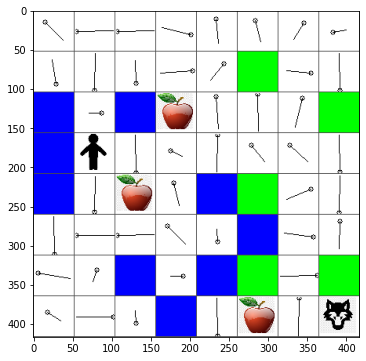

In [12]:
m.plot(Q)

## Het beleid controleren

Aangezien de Q-Table de "aantrekkelijkheid" van elke actie in elke staat weergeeft, is het vrij eenvoudig om deze te gebruiken om efficiënte navigatie in onze wereld te definiëren. In het eenvoudigste geval kunnen we gewoon de actie kiezen die overeenkomt met de hoogste Q-Table waarde:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Als je de bovenstaande code meerdere keren probeert, merk je misschien dat deze soms gewoon "vastloopt", en je de STOP-knop in het notebook moet indrukken om het te onderbreken.

> **Taak 1:** Pas de `walk`-functie aan om de maximale lengte van het pad te beperken tot een bepaald aantal stappen (bijvoorbeeld 100), en kijk hoe de bovenstaande code deze waarde van tijd tot tijd retourneert.

> **Taak 2:** Pas de `walk`-functie aan zodat deze niet terugkeert naar plaatsen waar hij eerder al is geweest. Dit zal voorkomen dat `walk` in een lus terechtkomt, maar de agent kan nog steeds "vast" komen te zitten op een locatie waaruit hij niet kan ontsnappen.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


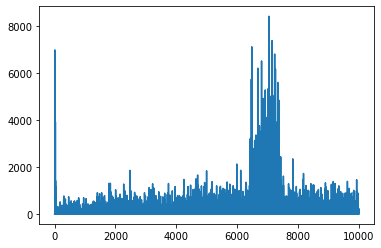

In [15]:
plt.plot(lpath)

Wat we hier zien, is dat de gemiddelde padlengte in het begin toenam. Dit komt waarschijnlijk doordat we, wanneer we niets weten over de omgeving, geneigd zijn vast te lopen in slechte situaties, zoals water of een wolf. Naarmate we meer leren en deze kennis beginnen te gebruiken, kunnen we de omgeving langer verkennen, maar weten we nog steeds niet goed waar de appels zich bevinden.

Zodra we genoeg hebben geleerd, wordt het voor de agent gemakkelijker om het doel te bereiken, en begint de padlengte af te nemen. We blijven echter openstaan voor verkenning, waardoor we vaak afwijken van het beste pad en nieuwe opties verkennen, wat het pad langer maakt dan optimaal.

Wat we ook op deze grafiek zien, is dat de lengte op een bepaald moment abrupt toenam. Dit wijst op de stochastische aard van het proces en dat we op een gegeven moment de Q-Table-coëfficiënten kunnen "verpesten" door ze te overschrijven met nieuwe waarden. Dit zou idealiter geminimaliseerd moeten worden door de leersnelheid te verlagen (d.w.z. tegen het einde van de training passen we de Q-Table-waarden slechts met een kleine waarde aan).

Over het algemeen is het belangrijk om te onthouden dat het succes en de kwaliteit van het leerproces sterk afhangen van parameters, zoals de leersnelheid, de afname van de leersnelheid en de discontovoet. Deze worden vaak **hyperparameters** genoemd, om ze te onderscheiden van **parameters** die we tijdens de training optimaliseren (bijv. Q-Table-coëfficiënten). Het proces van het vinden van de beste hyperparameterwaarden wordt **hyperparameteroptimalisatie** genoemd, en dit verdient een apart onderwerp.


## Oefening
#### Een Meer Realistische Wereld van Peter en de Wolf

In onze situatie kon Peter zich bijna zonder moe te worden of honger te krijgen verplaatsen. In een meer realistische wereld moet hij af en toe gaan zitten om uit te rusten en zichzelf voeden. Laten we onze wereld realistischer maken door de volgende regels toe te passen:

1. Door van de ene plek naar de andere te bewegen, verliest Peter **energie** en krijgt hij **vermoeidheid**.
2. Peter kan meer energie krijgen door appels te eten.
3. Peter kan vermoeidheid kwijtraken door uit te rusten onder de boom of op het gras (d.w.z. door naar een bordlocatie met een boom of gras - groen veld - te lopen).
4. Peter moet de wolf vinden en doden.
5. Om de wolf te doden, moet Peter bepaalde niveaus van energie en vermoeidheid hebben, anders verliest hij het gevecht.

Pas de beloningsfunctie hierboven aan volgens de regels van het spel, voer het reinforcement learning-algoritme uit om de beste strategie te leren om het spel te winnen, en vergelijk de resultaten van willekeurige bewegingen met je algoritme in termen van het aantal gewonnen en verloren spellen.

> **Note**: Het kan nodig zijn om hyperparameters aan te passen om het te laten werken, vooral het aantal epochs. Omdat het succes van het spel (het vechten tegen de wolf) een zeldzame gebeurtenis is, kun je een veel langere trainingstijd verwachten.



---

**Disclaimer**:  
Dit document is vertaald met behulp van de AI-vertalingsservice [Co-op Translator](https://github.com/Azure/co-op-translator). Hoewel we streven naar nauwkeurigheid, willen we u erop wijzen dat geautomatiseerde vertalingen fouten of onnauwkeurigheden kunnen bevatten. Het originele document in de oorspronkelijke taal moet worden beschouwd als de gezaghebbende bron. Voor kritieke informatie wordt professionele menselijke vertaling aanbevolen. Wij zijn niet aansprakelijk voor misverstanden of verkeerde interpretaties die voortvloeien uit het gebruik van deze vertaling.
